In [2]:
# import modules
import sys
from os import listdir, path
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from IPython.display import clear_output
import xarray as xr

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [7]:
!conda install -y pytorch==2.0.1 torchvision==0.15.2 pytorch-cuda=11.7 -c pytorch -c nvidia
!pip install xarray

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::lcms2==2.12=h3be6417_0
  - defaults/linux-64::pytables==3.6.1=py38h9fd0a39_0
  - defaults/linux-64::libtiff==4.2.0=h85742a9_0
  - defaults/linux-64::anaconda-navigator==2.0.3=py38_0
  - defaults/linux-64::blosc==1.21.0=h8c45485_0
  - defaults/noarch::imageio==2.9.0=pyhd3eb1b0_0
  - pytorch/linux-64::torchvision==0.15.2=py38_cu117
  - defaults/noarch::dask==2021.10.0=pyhd3eb1b0_0
  - defaults/linux-64::libwebp==1.2.0=h89dd481_0
  - defaults/linux-64::anaconda==custom=py38_1
  - defaults/noarch::seaborn==0.11.2=pyhd3eb1b0_0
  - defaults/linux-64::openjpeg==2.4.0=h3ad879b_0
  - defaults/linux-64::scikit-image==0.18.3=py38h51133e4_0
  - defaults/linux-64::pillow==8.4.0=py38h5aabda8_0
  - defaults/linux-64::matplotlib-base==3.5.0=py38h3ed280b_0
  - defaults/noarch::tifffile==2021.7.2=pyhd3eb1b0_2
  - defaults/linux-64:

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# constnats
AREA_WIDTH  = 17000
AREA_HIGHT = 3500

BLOCK_WIDTH  = 400
BLOCK_HEIGHT = 100

NUMBER_OF_SAMPLE = 301#401
NUMBER_OF_RECEIVERS = 341#401

Nx = 341
Ny = 351

dx = AREA_WIDTH / (Nx-1)
dy = AREA_HIGHT / (Ny-1)

In [5]:
print(f'Grid steps dx : {dx}, dy : {dy}')
nx, ny = int(BLOCK_WIDTH/dx), int(BLOCK_HEIGHT/dy)
print(f'Block size in nodes : ({nx}, {ny})')

Grid steps dx : 50.0, dy : 10.0
Block size in nodes : (8, 10)


# Предсказание угла и коэифцента трения

In [13]:
import struct

dir = "./dataset/vtk/"
# seismograms
X = []
# target angle
y_alpha = []
# target mu
y_mu = []

x_p = np.arange(Nx, dtype='int')
y_p = np.arange(Ny, dtype='int')
X_p, Y_p = np.meshgrid(x_p, y_p)

# read signals
for file in listdir(dir):
    with open(dir+file, 'rb') as fd :
        str = file.split('_')
        x0 = int(9800/dx)#int(int(str[1])/dx)
        y0 = int(1100/dy)#int(int(str[2])/dy)

        signal = np.zeros(shape=(2, NUMBER_OF_SAMPLE, NUMBER_OF_RECEIVERS), dtype=np.float64)
        for i in range(NUMBER_OF_SAMPLE):
            ts = struct.unpack('d', fd.read(8))
            tmp = np.frombuffer(fd.read(8 * NUMBER_OF_RECEIVERS * 2), dtype=np.float64)
            if(tmp.size == 0):
                break
            signal[0, i, :] = tmp[::2] #- X_empty[0, i, :]#vx
            signal[1, i, :] = tmp[1::2] #- X_empty[1, i, :]#vy

        X.append(signal)
        y_alpha.append(int(str[1]))
        mu = int(str[2][:str[2].find('.')]) / 20 * 0.3 + 0.003
        y_mu.append(mu)

Text(0.5, 1.0, 'Data: 301 records, 341 receivers per sample')

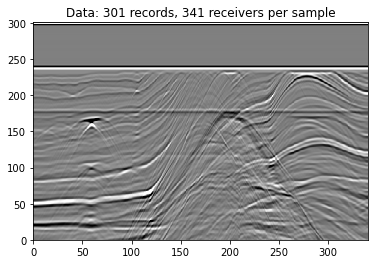

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, ax1 = plt.subplots()
ax1.pcolormesh(X[0][1][::-1,:], cmap=cm.gray, vmin=-1e-5, vmax=1e-5)
ax1.set_title(f'Data: {NUMBER_OF_SAMPLE} records, {NUMBER_OF_RECEIVERS} receivers per sample')

In [24]:
from sklearn.model_selection import train_test_split
from copy import deepcopy
from torchvision.transforms import Resize
from random import shuffle

test_size = 0.2
batch_size = 32
ind_split = int(len(X) * test_size)
inds = [i for i in range(len(X))]
shuffle(inds)

X_test, y_a_test, y_mu_test = np.array(X)[inds[:ind_split]], np.array(y_alpha)[inds[:ind_split]], np.array(y_mu)[inds[:ind_split]]
X_train, y_a_train, y_mu_train = np.array(X)[inds[ind_split:]],np.array(y_alpha)[inds[ind_split:]], np.array(y_mu)[inds[ind_split:]]

resize = Resize((Ny, Nx))

class SeismicDataset(Dataset):
    def __init__(self, X, y_a, y_mu, transform=resize):
        self.transform=transform
        self.X = deepcopy(X)
        self.y_a = deepcopy(y_a)
        self.y_mu = deepcopy(y_a)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X_out = torch.tensor(self.X[idx].copy())
        return  self.transform(X_out), torch.tensor(self.y_a[idx].copy()), torch.tensor(self.y_mu[idx].copy())

train_dataset = SeismicDataset(X_train, y_a_train, y_mu_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataset = SeismicDataset(X_test, y_a_test, y_mu_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [32]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2, stride=2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

class CNN(nn.Module):
    def __init__(self, in_channels=1, out_classes=1, up_sample_mode='ConvTranspose2d'):
        super(CNN, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(in_channels, 16)
        self.down_conv2 = DownBlock(16, 32)
        self.down_conv3 = DownBlock(32, 64)
        # Final Convolution
        self.FC = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(28224, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        #x, skip4_out = self.down_conv4(x)
        x = self.FC(x)
        return x

In [33]:
class Loss_Metrics_Mem(object):

    def __init__(self, gamma=1.):
        super().__init__()
        self.gamma = gamma
        self.loss = None
        self.loss_h = []
        self.val_loss_h = []
        self.metrics_h = []

    def upd_loss(self, loss_val):
        if self.loss is None:
            self.loss = loss_val
        else:
            self.loss = self.loss + loss_val

    def clean_loss(self):
        self.loss = None

    def upd_metrics(self, loss_val, metrics_val):
        self.val_loss_h.append(loss_val)
        self.metrics_h.append(metrics_val)
        self.loss_h.append(self.loss)

    def plot(self, axes):
        xlen = len(self.loss_h)
        axes[0].plot(range(xlen), self.loss_h, label='train')
        axes[0].plot(range(xlen), self.val_loss_h, label='test')
        axes[0].legend()
        axes[1].plot(range(xlen), self.metrics_h, label='test r2')

In [35]:
from sklearn.metrics import r2_score

model = CNN(in_channels = 2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
Loss = nn.MSELoss()
l_m = Loss_Metrics_Mem()

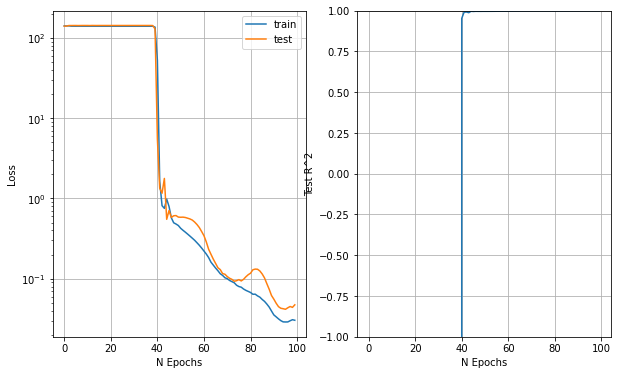

0.0473303753276204 0.9996588635138978


In [36]:
N_epochs = 100

for epoch in range(N_epochs):

    y_pred_val = torch.tensor([0])
    y_true_val = torch.tensor([0])

    loss_val = 0

    model.train()
    for X, y, _ in train_dataloader:
        X = X.float()
        X_out = model(X.to(device)).squeeze()
        loss = Loss(X_out.float(), y.to(device).float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        l_m.upd_loss(loss.item() * torch.numel(y) / len(train_dataset))
    #model.eval()
    with torch.no_grad():
        for X, y, _ in test_dataloader:
            X = X.float()
            y_pred = model(X.to(device)).squeeze().to('cpu')
            loss = Loss(y.float(), y_pred.float())

            loss_val += loss.item() * torch.numel(y) / len(test_dataset)

            if torch.numel(y_pred) > 1:
                y_pred_val = torch.cat((y_pred_val, y_pred), dim=0)
                y_true_val = torch.cat((y_true_val, y.to('cpu')), dim=0)
    l_m.upd_metrics(loss_val,
                        r2_score(y_pred_val.squeeze().detach().cpu().numpy(),
                                y_true_val.detach().cpu().numpy()))

    clear_output()
    # plot losses
    fig, axes = plt.subplots(1, 2, figsize=(10,6))
    axes[0].set_xlabel('N Epochs')
    axes[0].grid()
    axes[1].grid()
    axes[0].set_ylabel('Loss')
    axes[0].set_yscale('log')
    axes[1].set_xlabel('N Epochs')
    axes[1].set_ylabel('Test R^2')
    axes[1].set_ylim([-1, 1])
    l_m.plot(axes)
    plt.show()

    print(l_m.val_loss_h[-1], l_m.metrics_h[-1])

    l_m.clean_loss()

In [38]:
from sklearn.metrics import r2_score

model_mu = CNN(in_channels = 2)
model_mu.to(device)
optimizer = torch.optim.Adam(model_mu.parameters(), lr=2e-4, weight_decay=1e-4)
Loss = nn.MSELoss()
l_m = Loss_Metrics_Mem()

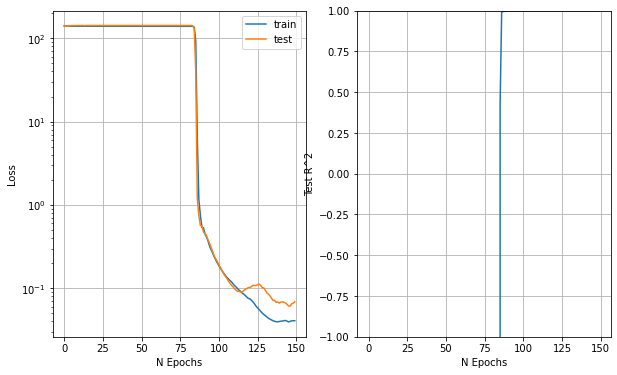

0.06909226002388223 0.9995146614176788


In [40]:
N_epochs = 50

for epoch in range(N_epochs):

    y_pred_val = torch.tensor([0])
    y_true_val = torch.tensor([0])

    loss_val = 0

    model_mu.train()
    for X, _, y in train_dataloader:
        X = X.float()
        X_out = model_mu(X.to(device)).squeeze()
        loss = Loss(X_out.float(), y.to(device).float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        l_m.upd_loss(loss.item() * torch.numel(y) / len(train_dataset))
    #model.eval()
    with torch.no_grad():
        for X, _, y in test_dataloader:
            X = X.float()
            y_pred = model_mu(X.to(device)).squeeze().to('cpu')
            loss = Loss(y.float(), y_pred.float())

            loss_val += loss.item() * torch.numel(y) / len(test_dataset)

            if torch.numel(y_pred) > 1:
                y_pred_val = torch.cat((y_pred_val, y_pred), dim=0)
                y_true_val = torch.cat((y_true_val, y.to('cpu')), dim=0)
    l_m.upd_metrics(loss_val,
                        r2_score(y_pred_val.squeeze().detach().cpu().numpy(),
                                y_true_val.detach().cpu().numpy()))

    clear_output()
    # plot losses
    fig, axes = plt.subplots(1, 2, figsize=(10,6))
    axes[0].set_xlabel('N Epochs')
    axes[0].grid()
    axes[1].grid()
    axes[0].set_ylabel('Loss')
    axes[0].set_yscale('log')
    axes[1].set_xlabel('N Epochs')
    axes[1].set_ylabel('Test R^2')
    axes[1].set_ylim([-1, 1])
    l_m.plot(axes)
    plt.show()

    print(l_m.val_loss_h[-1], l_m.metrics_h[-1])

    l_m.clean_loss()

## dataset_mixed

In [6]:
import struct

dir = "./dataset_mixed/vtk/"
# seismograms
X = {}
# target boxes
y = {}
# scalars
y_s = {}
weight_mask = {}

mask = np.zeros((Ny, Nx), dtype='bool')

x_p = np.arange(Nx, dtype='int')
y_p = np.arange(Ny, dtype='int')

X_p, Y_p = np.meshgrid(x_p, y_p)

# read signals
for file in listdir(dir):
    with open(dir+file, 'rb') as fd :
        str = file.split('_')
        x0 = int(int(str[1])/dx)
        y0 = int(int(str[2])/dy)
        y_sc = float(int(str[3][:str[3].find('.')]))

        signal = np.zeros(shape=(2, NUMBER_OF_SAMPLE, NUMBER_OF_RECEIVERS), dtype=np.float64)
        for i in range(NUMBER_OF_SAMPLE):
            ts = struct.unpack('d', fd.read(8))
            tmp = np.frombuffer(fd.read(8 * NUMBER_OF_RECEIVERS * 2), dtype=np.float64)
            if(tmp.size == 0):
                break
            signal[0, i, :] = tmp[::2] #- X_empty[0, i, :]#vx
            signal[1, i, :] = tmp[1::2] #- X_empty[1, i, :]#vy

        key = (x0, y0)

        dist = np.abs(X_p - \
                      ( (X_p < x0) * x0 + (X_p > (x0+nx)) * (x0+nx) + (X_p >= x0) * (X_p <= (x0+nx)) * X_p  )  )/ (5*nx) \
                      + np.abs(Y_p - \
                      ( (Y_p < y0) * y0 + (Y_p > (y0+ny)) * (y0+ny) + (Y_p >= y0) * (Y_p <= (y0+ny)) * Y_p  ) ) / (5*ny)

        tmp = np.exp(-dist)+ 15 / np.sqrt(Nx*Ny)

        if (key in X.keys()):
            X[key].append(signal)
            y[key].append(np.copy(mask))
            y[key][-1][y0:(y0+ny), x0:(x0+nx)] = 1
            y_s[key].append(y_sc)
            weight_mask[key].append(tmp)

        else:
            X[key] = [signal]
            y[key] = [np.copy(mask)]
            y[key][-1][y0:(y0+ny), x0:(x0+nx)] = 1
            y_s[key] = [y_sc]
            weight_mask[key] = [tmp]

-10.0 8.0


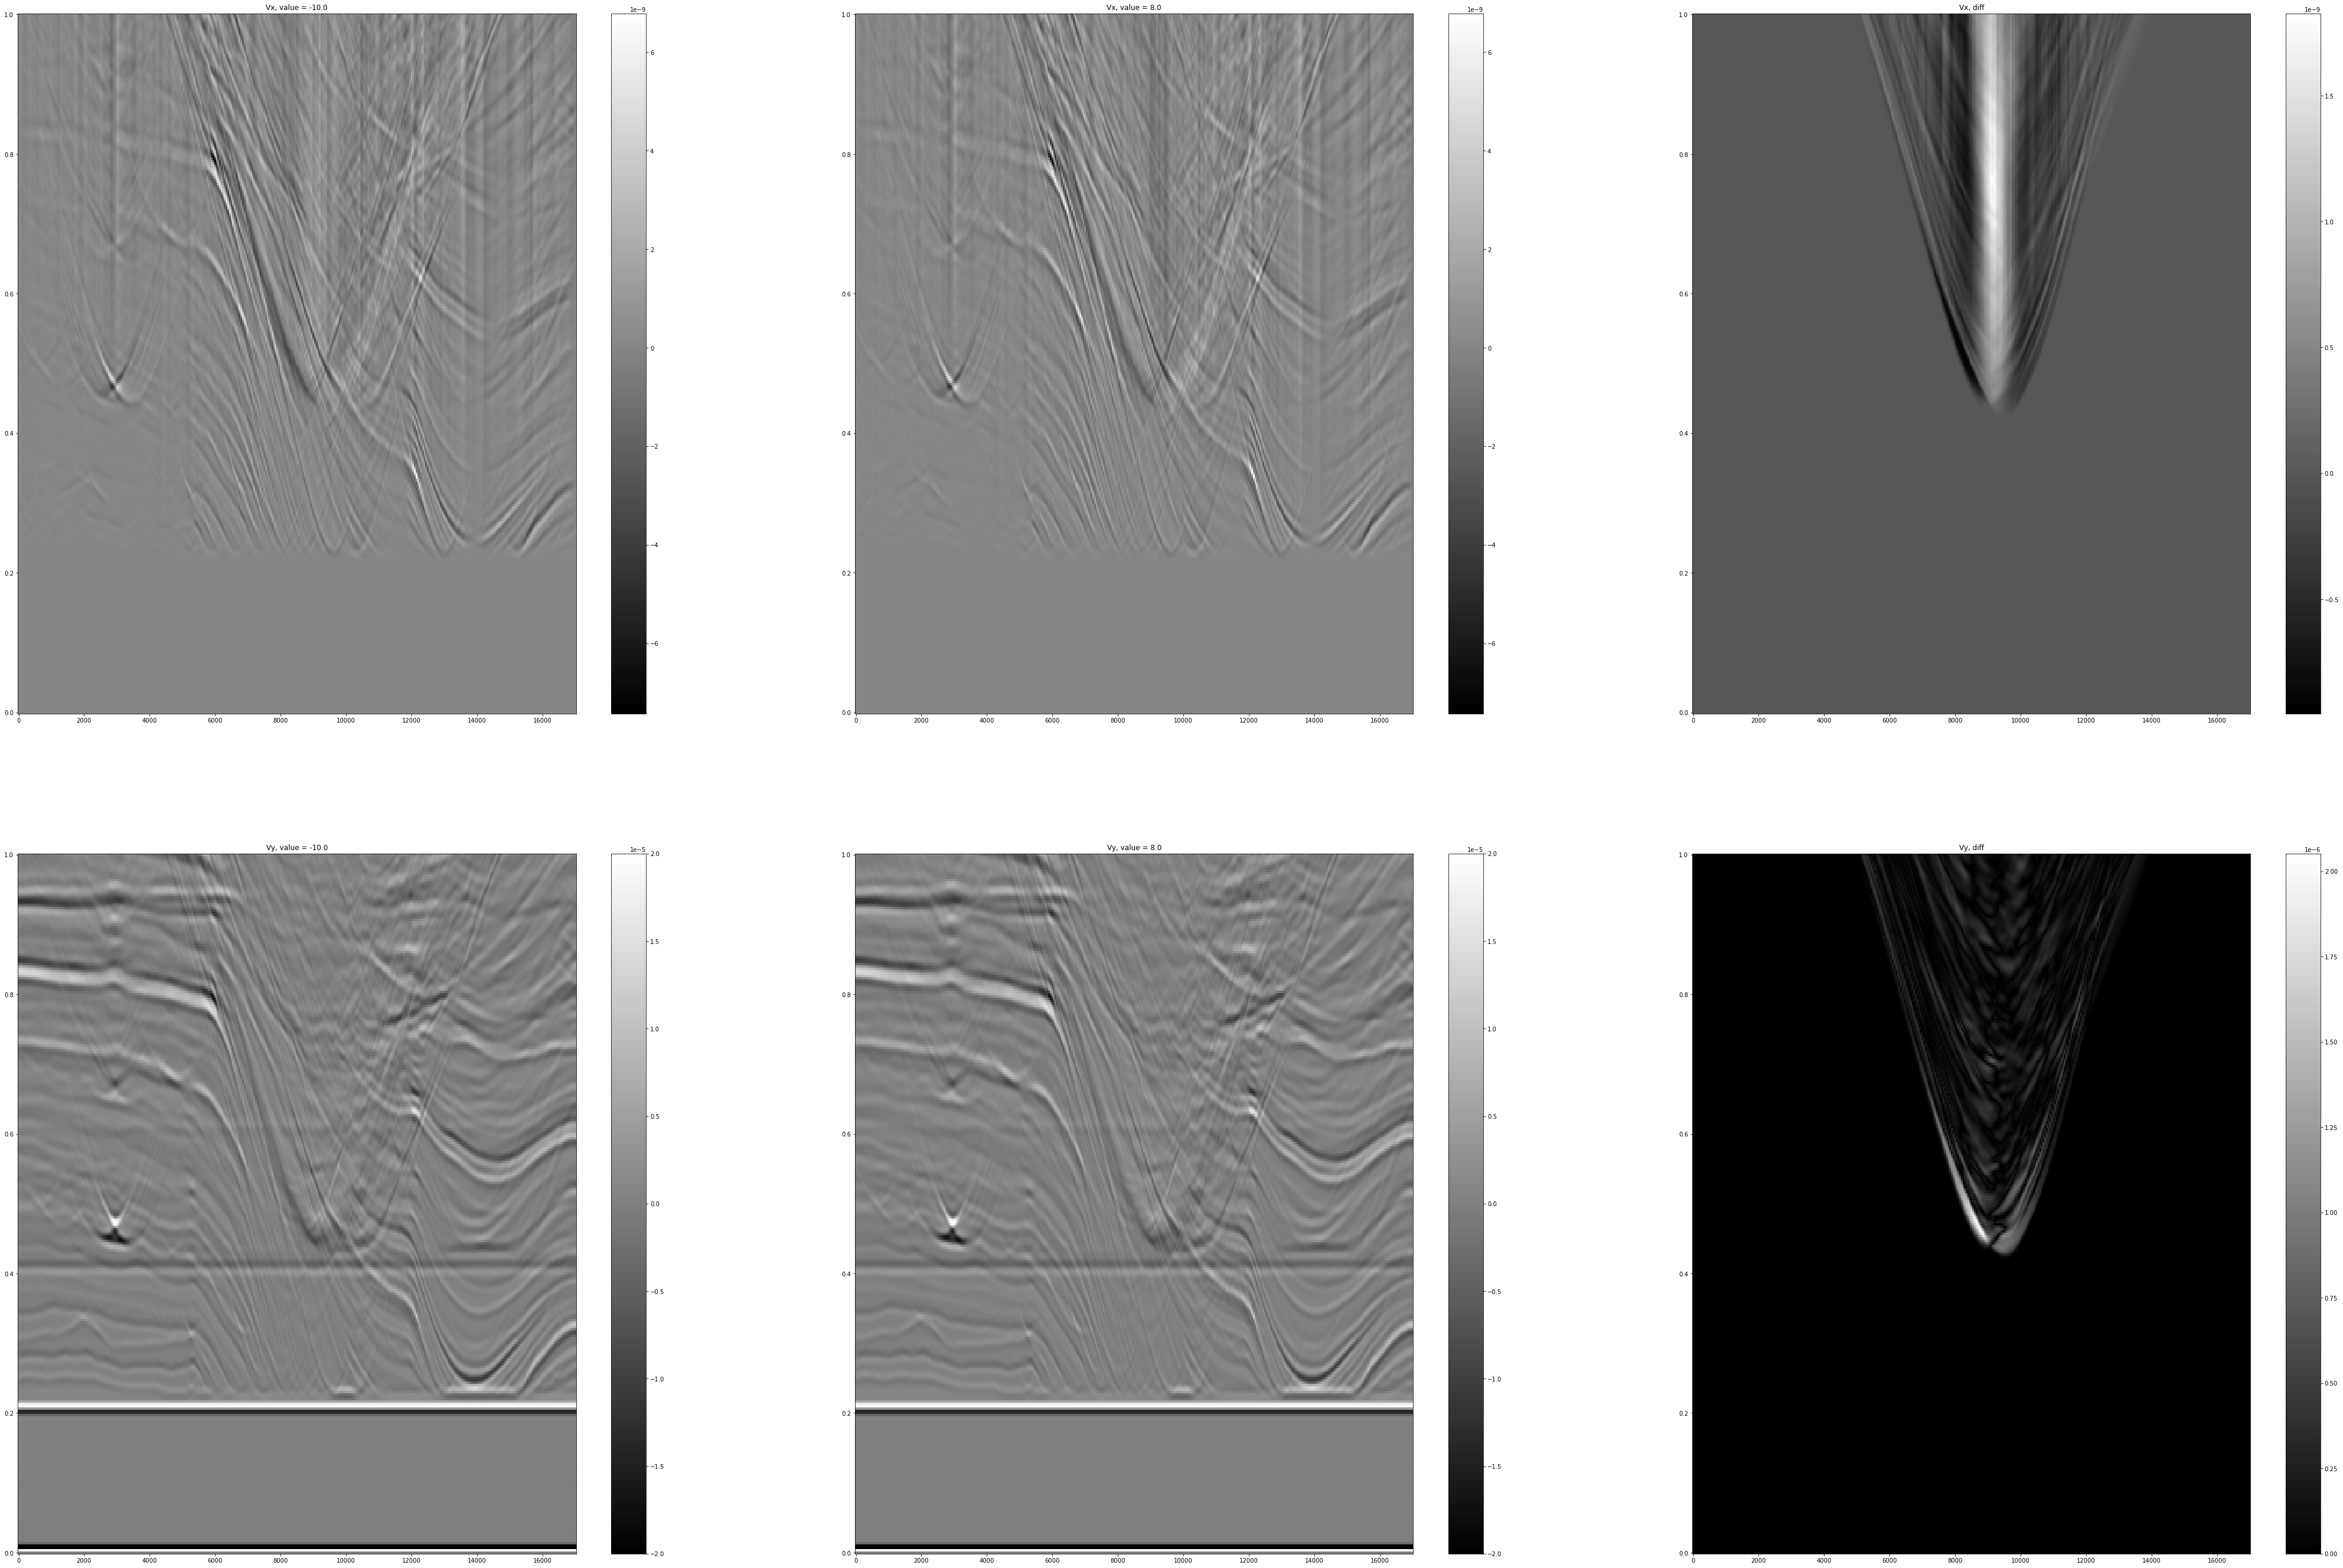

In [7]:
from matplotlib.pyplot import cm

# diference between two samples with same boxes
key = (int(9000/dx), int(1100/dy))
X_1 = X[key][0]
X_2 = X[key][-1]

v = np.max(abs(X_1))

x = np.linspace(0, AREA_WIDTH, NUMBER_OF_RECEIVERS)
t = np.linspace(0, 1, NUMBER_OF_SAMPLE)

fig, ax = plt.subplots(2, 3, figsize = (3*24, 3*16))
im = ax[0, 0].pcolormesh(x, t, X_1[0, :], cmap=cm.gray)
plt.colorbar(im, ax=ax[0, 0])
ax[0, 0].set_title(f'Vx, value = {y_s[key][0]}')
im = ax[0, 1].pcolormesh(x, t, X_2[0, :], cmap=cm.gray)
plt.colorbar(im, ax=ax[0, 1])
ax[0, 1].set_title(f'Vx, value = {y_s[key][-1]}')
im = ax[0, 2].pcolormesh(x, t, X_1[0, :]-X_2[0, :], cmap=cm.gray)
plt.colorbar(im, ax=ax[0, 2])
ax[0, 2].set_title(f'Vx, diff')

print(y_s[key][0], y_s[key][-1])

im = ax[1, 0].pcolormesh(x, t, X_1[1, :], cmap=cm.gray, vmax=2e-5, vmin=-2e-5)
plt.colorbar(im, ax=ax[1, 0])
ax[1, 0].set_title(f'Vy, value = {y_s[key][0]}')
im = ax[1, 1].pcolormesh(x, t, X_2[1, :], cmap=cm.gray, vmax=2e-5, vmin=-2e-5)
plt.colorbar(im, ax=ax[1, 1])
ax[1, 1].set_title(f'Vy, value = {y_s[key][-1]}')
im = ax[1, 2].pcolormesh(x, t, np.abs(X_1[1, :]-X_2[1, :]), cmap=cm.gray)
plt.colorbar(im, ax=ax[1, 2])
ax[1, 2].set_title(f'Vy, diff')

plt.show()

In [8]:
# train.test split
import random
from copy import deepcopy
from random import shuffle
from random import sample

test_size = 0.2
batch_size = 32

keys = list(X.keys())
random.shuffle(keys)
ind_split = int(len(keys) * test_size)

test_keys = keys[0:ind_split]
train_keys = keys[ind_split:-1]

X_test, y_test, y_s_test = [], [], []

test_dict_x = {}
test_dict_y_s = {}
for key in test_keys:
    ind = [i for i in range(len(X[key]))]
    shuffle(ind)
    test_dict_x[key] = [X[key][i] for i in ind]
    test_dict_y_s[key] = [y_s[key][i] for i in ind]

while test_dict_x.keys():
    if batch_size < len(test_dict_x.keys()):
        selected_keys = random.sample(test_dict_x.keys(), batch_size)
    else:
        selected_keys = test_dict_x.keys()
    for key in deepcopy(list(selected_keys)):
        X_test.append(test_dict_x[key].pop())
        y_test.append(y[key][0])
        y_s_test.append(test_dict_y_s[key].pop())
        if len(test_dict_x[key]) == 0 :
            test_dict_x.pop(key, None)
            test_dict_y_s.pop(key, None)

X_train, y_train, y_s_train = [], [], []

train_dict_x = {}
train_dict_y_s = {}
for key in train_keys:
    ind = [i for i in range(len(X[key]))]
    shuffle(ind)
    train_dict_x[key] = [X[key][i] for i in ind]
    train_dict_y_s[key] = [y_s[key][i] for i in ind]

while train_dict_x.keys():
    if batch_size < len(train_dict_x.keys()):
        selected_keys = random.sample(train_dict_x.keys(), batch_size)
    else:
        selected_keys = train_dict_x.keys()
    for key in deepcopy(list(selected_keys)):
        X_train.append(train_dict_x[key].pop())
        y_train.append(y[key][0])
        y_s_train.append(train_dict_y_s[key].pop())
        if len(train_dict_x[key]) == 0 :
            train_dict_x.pop(key, None)
            train_dict_y_s.pop(key, None)


In [9]:
# mean X signal

X_mean = np.zeros((2, NUMBER_OF_SAMPLE, NUMBER_OF_RECEIVERS))

for x_el in X_train:
        X_mean += x_el / len(X_train)

for i in range(len(X_train)):
    X_train[i] -= X_mean

for i in range(len(X_test)):
    X_test[i] -= X_mean

In [10]:
from sklearn.model_selection import train_test_split
from copy import deepcopy
from torchvision.transforms import Resize

resize = Resize((Ny, Nx))

class SeismicDataset(Dataset):
    def __init__(self, X, y, y_s, transform=resize):
        self.transform=transform
        self.X = deepcopy(X)
        self.y = deepcopy(y)
        self.y_s = deepcopy(y_s)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        #print(self.X[idx].shape)
        X_out = torch.tensor(self.X[idx].copy())
        return  self.transform(X_out), torch.tensor(self.y[idx].copy()), torch.tensor(self.y_s[idx])

train_dataset = SeismicDataset(X_train, y_train, y_s_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataset = SeismicDataset(X_test, y_test, y_s_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Model


In [66]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class CNN_st(nn.Module):
    def __init__(self, in_channels=2):
        super(CNN_st, self).__init__()
        # Downsampling Path
        self.down_conv1 = DownBlock(in_channels, 16)
        self.down_conv2 = DownBlock(16, 32)
        self.down_conv3 = DownBlock(32, 64)
        self.down_conv4 = DownBlock(64, 64) # 43 x 42 out
        self.down_conv5 = DownBlock(64, 32) # 21 x 12 out
        self.down_conv6 = DownBlock(32, 16) # 5 x 5 out
        self.down_conv7 = DownBlock(16, 1) # 2 x 2 out
        # Final FC
        self.FC = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(4, 1),
        )

    def forward(self, x):
        x, _ = self.down_conv1(x)
        x, _ = self.down_conv2(x)
        x, _ = self.down_conv3(x)
        x, _ = self.down_conv4(x)
        x, _ = self.down_conv5(x)
        x, _ = self.down_conv6(x)
        x, _ = self.down_conv7(x)

        x = self.FC(x)
        return x

In [67]:
class Loss_Metrics_Mem(object):

    def __init__(self, gamma=1.):
        super().__init__()
        self.gamma = gamma
        self.loss = None
        self.loss_h = []
        self.val_loss_h = []
        self.metrics_h = []

    def upd_loss(self, loss_val):
        if self.loss is None:
            self.loss = loss_val
        else:
            self.loss = self.loss + loss_val

    def clean_loss(self):
        self.loss = None

    def upd_metrics(self, loss_val, metrics_val):
        self.val_loss_h.append(loss_val)
        self.metrics_h.append(metrics_val)
        self.loss_h.append(self.loss)

    def plot(self, axes):
        xlen = len(self.loss_h)
        axes[0].plot(range(xlen), self.loss_h, label='train')
        axes[0].plot(range(xlen), self.val_loss_h, label='test')
        axes[0].legend()
        axes[1].plot(range(xlen), self.metrics_h, label='test r2')

In [81]:
from sklearn.metrics import r2_score

model = CNN_st(in_channels = 2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
Loss = nn.MSELoss()
l_m = Loss_Metrics_Mem()

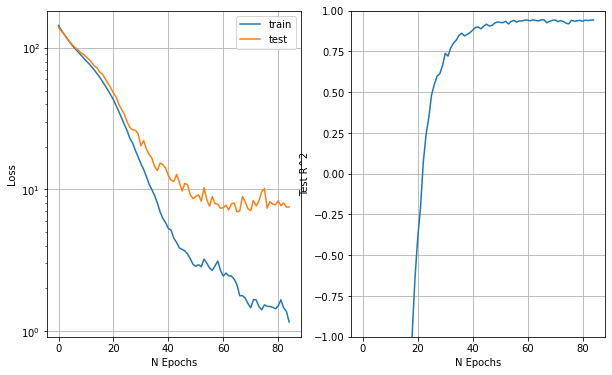

7.515997328555075 0.9425972133411088


In [82]:
N_epochs = 85

for epoch in range(N_epochs):
    
    y_pred_val = torch.tensor([0])
    y_true_val = torch.tensor([0])
    
    loss_val = 0
    
    model.train()
    for X, _, y in train_dataloader:
        X = X.float()
        X_out = model(X.to(device)).squeeze()
        loss = Loss(X_out.float(), y.to(device).float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        l_m.upd_loss(loss.item() * torch.numel(y) / len(train_dataset))
    #model.eval()
    with torch.no_grad():
        for X, _, y in test_dataloader:
            X = X.float()
            y_pred = model(X.to(device)).squeeze().to('cpu')
            loss = Loss(y.float(), y_pred.float())

            loss_val += loss.item() * torch.numel(y) / len(test_dataset)
            
            if torch.numel(y_pred) > 1:
                y_pred_val = torch.cat((y_pred_val, y_pred), dim=0)
                y_true_val = torch.cat((y_true_val, y.to('cpu')), dim=0)
    l_m.upd_metrics(loss_val, 
                        r2_score(y_pred_val.squeeze().detach().cpu().numpy(),
                                y_true_val.detach().cpu().numpy()))

    clear_output()
    # plot losses
    fig, axes = plt.subplots(1, 2, figsize=(10,6))
    axes[0].set_xlabel('N Epochs')
    axes[0].grid()
    axes[1].grid()
    axes[0].set_ylabel('Loss')
    axes[0].set_yscale('log')
    axes[1].set_xlabel('N Epochs')
    axes[1].set_ylabel('Test R^2')
    axes[1].set_ylim([-1, 1])
    l_m.plot(axes)
    plt.show()
    
    print(l_m.val_loss_h[-1], l_m.metrics_h[-1])

    l_m.clean_loss()

In [89]:
y_pred_val = torch.tensor([0])
y_true_val = torch.tensor([0])

with torch.no_grad():
        for X, _, y in test_dataloader:
            X = X.float()
            y_pred = model(X.to(device)).squeeze().to('cpu')
            loss = Loss(y.float(), y_pred.float())

            loss_val += loss.item() * torch.numel(y) / len(test_dataset)

            if torch.numel(y_pred) > 1:
                y_pred_val = torch.cat((y_pred_val, y_pred), dim=0)
                y_true_val = torch.cat((y_true_val, y.to('cpu')), dim=0)

y_pred_val = y_pred_val[1::]
y_true_val = y_true_val[1::]

In [90]:
positions_test = np.unique(np.array(y_test), axis= 0)

In [85]:
x_0 = []
y_0 = []

for position in positions_test:
    x_0.append(np.argwhere(position)[:, 0].min() * dx)
    y_0.append(np.argwhere(position)[:, 1].min() * dy)

In [86]:
ind = np.argsort(y_0)
x_0 = np.array(x_0)[ind]
y_0 = np.array(y_0)[ind]
positions_test = positions_test[ind]

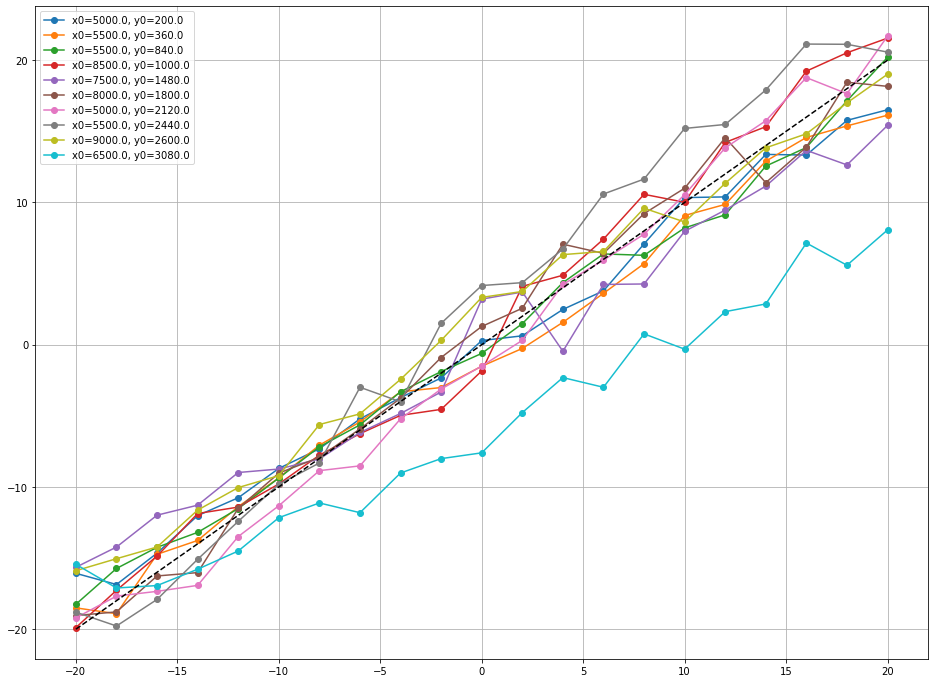

In [92]:
fig, ax = plt.subplots(figsize = (16, 12))

for position, x0, y0 in zip(positions_test[::4], x_0[::4], y_0[::4]):
    filter = np.sum(np.abs(1 * y_test- 1* position), axis = (1, 2)) == 0
    ind_sort = np.argsort(y_true_val[filter])
    x1 = y_true_val[filter][ind_sort]
    y1 = y_pred_val[filter][ind_sort]
    
    plt.plot(x1, y1, marker='o', label=f'x0={x0}, y0={y0}')

plt.plot([-20, 20], [-20, 20], linestyle='--', color='k')
plt.grid()
plt.legend()
plt.show()

# Совместное обучение

In [93]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode, size=None):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            if size == None:
                self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            else :
                self.up_sample = nn.Upsample(size = size, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

class CS_model(nn.Module):
    def __init__(self, in_channels=1, out_classes=1, up_sample_mode='bilinear'):
        super(CS_model, self).__init__()

        # U-net part
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(in_channels, 16)
        self.down_conv2 = DownBlock(16, 32)
        self.down_conv3 = DownBlock(32, 64)
        # Bottleneck
        self.double_conv = DoubleConv(64, 128)
        # Upsampling Path
        self.up_conv3 = UpBlock(64 + 128, 64, self.up_sample_mode, size=(87, 85))
        self.up_conv2 = UpBlock(64 + 32, 32, self.up_sample_mode, size=(175, 170))
        self.up_conv1 = UpBlock(32 + 16, 16, self.up_sample_mode, size=(351, 341))
        # Final Convolution
        self.conv_last = nn.Conv2d(16, out_classes, kernel_size=1)

        # scalar part
        self.down_conv1_sc = DownBlock(in_channels, 16)
        self.down_conv2_sc = DownBlock(16, 32)
        self.down_conv3_sc = DownBlock(32, 64)
        self.down_conv4_sc = DownBlock(64, 64)  # 43 x 42 out
        self.down_conv5_sc = DownBlock(64, 32)  # 21 x 12 out
        self.down_conv6_sc = DownBlock(32, 16)  # 10 x 10 out
        self.down_conv7_sc = DownBlock(16, 1)  # 5 x 5 out
        # Final FC
        self.FC = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(4, 1),
        )

        # CS-units
        self.cs1 = nn.Linear(2, 2)
        with torch.no_grad():
            self.cs1.weight[0, 0] = .9
            self.cs1.weight[0, 1] = .1
            self.cs1.weight[1, 0] = .1
            self.cs1.weight[1, 1] = .9
        self.cs2 = nn.Linear(2, 2)
        with torch.no_grad():
            self.cs2.weight[0, 0] = .9
            self.cs2.weight[0, 1] = .1
            self.cs2.weight[1, 0] = .1
            self.cs2.weight[1, 1] = .9

    def forward(self, x):
        x1, skip1_out = self.down_conv1(x)
        x2, _ = self.down_conv1_sc(x)

        x1_t, skip2_out = self.down_conv2(x1 * self.cs1.weight[0, 0] + x2 * self.cs1.weight[0, 1])
        x2_t, _ = self.down_conv2_sc(x1 * self.cs1.weight[1, 0] + x2 * self.cs1.weight[1, 1])

        x1, skip3_out = self.down_conv3(x1_t * self.cs2.weight[0, 0] + x2_t * self.cs2.weight[0, 1])
        x2, _ = self.down_conv3_sc(x1_t * self.cs2.weight[1, 0] + x2_t * self.cs2.weight[1, 1])

        x2, _ = self.down_conv4_sc(x2)
        x2, _ = self.down_conv5_sc(x2)
        x2, _ = self.down_conv6_sc(x2)
        x2, _ = self.down_conv7_sc(x2)
        x2 = self.FC(x2)

        x1 = self.double_conv(x1)

        x1 = self.up_conv3(x1, skip3_out)
        x1 = self.up_conv2(x1, skip2_out)
        x1 = self.up_conv1(x1, skip1_out)
        x1 = self.conv_last(x1)

        return x1, x2

In [94]:
class Loss_Metrics_Mem(object):
    
    def __init__(self):
        super().__init__()
        self.loss = None
        self.loss_h = []
        self.val_loss_h = []
        self.metrics_h = {}
        
    def upd_loss(self, loss_val):
        if self.loss is None:
             self.loss = loss_val
        else:
             self.loss = self.loss + loss_val
    def clean_loss(self):
        self.loss = None
            
    def upd_metrics(self, loss_val, metrics_val : dict):
        self.val_loss_h.append(loss_val)
        
        for key in metrics_val.keys() :
            if key in self.metrics_h.keys():
                self.metrics_h[key].append(metrics_val[key])
            else:
                self.metrics_h[key] = [metrics_val[key]]
        
        self.loss_h.append(self.loss)
        
    def plot(self, axes):
        xlen = len(self.loss_h)
        axes[0].plot(range(xlen), self.loss_h, label='train')
        axes[0].plot(range(xlen), self.val_loss_h, label='test')
        axes[0].legend()
        
        for key in self.metrics_h.keys():
            axes[1].plot(range(xlen), self.metrics_h[key], label=key)
            
        axes[1].legend()

In [95]:
def Precision(y, y_pred):
    TP = torch.sum((y >= 0.5) * (y_pred > 0.5), axis = (1, 2)) * 1./ Nx / Ny
    FP = torch.sum((y >= 0.5) * (y_pred < 0.5), axis = (1, 2)) * 1. / Nx / Ny
    return torch.sum( TP / (TP + FP + .5e-4) )

def Recall(y, y_pred):
    TP = torch.sum((y >= 0.5) * (y_pred > 0.5), axis = (1, 2)) * 1. / Nx / Ny
    FN = torch.sum((y < 0.5) * (y_pred > 0.5), axis = (1, 2)) * 1. / Nx / Ny
    return torch.sum(TP / (TP + FN + .5e-4))

def DiceScore(y_true, y_pred, gamma = 1):
    nominator = 2 * \
        torch.sum(y_pred * y_true, axis=(1, 2)) + 1e-5
    denominator = torch.sum(y_pred ** gamma, axis= (1, 2)) \
                  + torch.sum(y_true ** gamma, axis= (1, 2)) + 1e-5
    result = nominator / denominator
    return torch.sum(result)

def DistCent(Y, Y_pred):
    x_p = torch.linspace(0, 1, Y.shape[-1])
    y_p = torch.linspace(0, 1, Y.shape[-2])
    
    x_true = torch.clone(Y.float())
    x_pred = torch.clone(Y_pred)
    for i in range(torch.numel(x_p)):
        x_true[:, :, i] *= x_p[i]
        x_pred[:, :, i] *= x_p[i]
        
    denom_true = torch.sum(Y, axis = (1, 2))
    denom_pred = torch.sum(Y_pred, axis = (1, 2)) 
        
    x_c_t = torch.sum(x_true, axis = (1, 2)) / denom_true
    x_c_p = torch.sum(x_pred, axis = (1, 2)) / denom_pred
        
    y_true = torch.clone(Y.float())
    y_pred = torch.clone(Y_pred)
    for i in range(torch.numel(y_p)):
        y_true[:, i, :] *= y_p[i]
        y_pred[:, i, :] *= y_p[i]
        
    y_c_t = torch.sum(y_true, axis = (1, 2)) / denom_true
    y_c_p = torch.sum(y_pred, axis = (1, 2)) / denom_pred
    
    return torch.sum(1 - (x_c_t - x_c_p) ** 2 - (y_c_t - y_c_p) ** 2)

In [97]:
from sklearn.metrics import r2_score
from torch.nn import BCEWithLogitsLoss

model = CS_model(in_channels = 2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
l_m1 = Loss_Metrics_Mem()
l_m2 = Loss_Metrics_Mem()
weight_bce = torch.tensor(AREA_WIDTH / BLOCK_WIDTH)
Loss1 = BCEWithLogitsLoss(pos_weight=weight_bce)
Loss2 = nn.MSELoss()

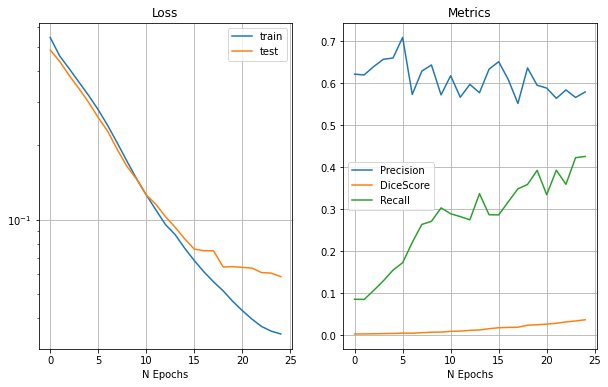

Loss on validation : 0.05878834024930658 
 Precision : 0.579663532419611 
  Dice score : 0.036486147190992704 
  Recall : 0.42587727831121075 


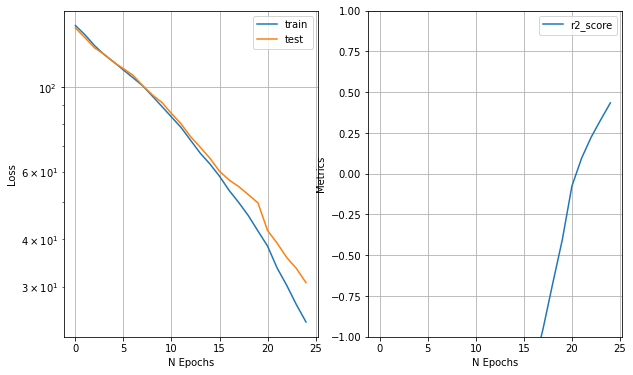

Loss on validation : 30.756719976439516 
 r2_score : 0.43418185088204986 
 


KeyboardInterrupt: 

In [98]:
N_epochs = 150

for epoch in range(N_epochs):
    
    y_pred_val = torch.tensor([0])
    y_true_val = torch.tensor([0])
    
    dist_score = 0.
    prec_score = 0.
    rec_score = 0.
    loss_val = 0.
    loss_val_s = 0.
    
    model.train()
    for X, y, y_s in train_dataloader:
        X = X.float()
        y1, y2 = model(X.to(device))
        y1 = y1.squeeze()
        y2 = y2.squeeze()
        loss1 = Loss1(y1.float(), y.to(device).float())
        loss2 = Loss2(y2.float(), y_s.to(device).float())
        
        loss = loss1 + loss2
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        l_m1.upd_loss(loss1.item() * torch.numel(y_s) / len(train_dataset))
        l_m2.upd_loss(loss2.item() * torch.numel(y_s) / len(train_dataset))
    #model.eval()
    with torch.no_grad():
        for X, _, y in test_dataloader:
            X = X.float()
            _, y_pred = model(X.to(device))
            y_pred = y_pred.squeeze().to('cpu')
            loss = Loss2(y.float(), y_pred.float())

            loss_val_s += loss.item() * torch.numel(y) / len(test_dataset)
            
            if torch.numel(y_pred) > 1:
                y_pred_val = torch.cat((y_pred_val, y_pred), dim=0)
                y_true_val = torch.cat((y_true_val, y.to('cpu')), dim=0)
    with torch.no_grad():
        for X,  y, _ in test_dataloader:
            #X = X[:, 1, :, :].float().unsqueeze(1)
            X = X.float()
            y = y.squeeze()
            y_pred, _ = model(X.to(device))
            y_pred = y_pred.squeeze().to('cpu')
            #Loss = BCEWithLogitsLoss(weight=wm.to(device))
            loss = Loss1(y_pred.to(device).float(), y.to(device).float())
            #mask = (y_pred.to('cpu') > 0) == y
            loss_val += loss.item() * y.shape[0] / len(test_dataset)
            #y_pred = torch.sigmoid(y_pred).to('cpu').detach()
            prec_score += Precision(y, torch.sigmoid(y_pred).to('cpu').detach() ).item() / len(test_dataset)
            dist_score += DiceScore(y, torch.sigmoid(y_pred).to('cpu').detach() ).item() / len(test_dataset)
            rec_score += Recall(y, torch.sigmoid(y_pred).to('cpu').detach() ).item() / len(test_dataset)

    l_m1.upd_metrics(loss_val,
                    {
                        'Precision' : prec_score,
                        'DiceScore' : dist_score,
                        'Recall' : rec_score
                    })
                
                
    l_m2.upd_metrics(loss_val_s,
                     { 'r2_score' : r2_score(y_pred_val.squeeze().detach().cpu().numpy(),
                                y_true_val.detach().cpu().numpy())} )

    clear_output()
    # plot losses
    fig, axes = plt.subplots(1, 2, figsize=(10,6))
    axes[0].set_xlabel('N Epochs')
    axes[0].grid()
    axes[1].grid()
    axes[0].set_title('Loss')
    axes[0].set_yscale('log')
    axes[1].set_xlabel('N Epochs')
    axes[1].set_title('Metrics')
    l_m1.plot(axes)
    plt.show()

    print(
        f'Loss on validation : { l_m1.val_loss_h[-1] } \n',
        'Precision : {} \n '.format(l_m1.metrics_h['Precision'][-1]),
        'Dice score : {} \n '.format(l_m1.metrics_h['DiceScore'][-1]),
        'Recall : {} '.format(l_m1.metrics_h['Recall'][-1]),
    )

    l_m1.clean_loss()
    
    fig, axes = plt.subplots(1, 2, figsize=(10,6))
    axes[0].set_xlabel('N Epochs')
    axes[0].grid()
    axes[1].grid()
    axes[0].set_ylabel('Loss')
    axes[0].set_yscale('log')
    axes[1].set_xlabel('N Epochs')
    axes[1].set_ylabel('Metrics')
    axes[1].set_ylim([-1, 1])
    l_m2.plot(axes)
    plt.show()
    
    print(
        f'Loss on validation : { l_m2.val_loss_h[-1] } \n',
        'r2_score : {} \n '.format(l_m2.metrics_h['r2_score'][-1])
    )

    l_m2.clean_loss()

In [101]:
class U_net_cat(nn.Module):
    def __init__(self, in_channels=1, out_classes=1, up_sample_mode='bilinear'):
        super(U_net_cat, self).__init__()

        # U-net part
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(in_channels, 16)
        self.down_conv2 = DownBlock(16, 32)
        self.down_conv3 = DownBlock(32, 64)
        # Bottleneck
        self.double_conv = DoubleConv(64, 128)
        # Upsampling Path
        self.up_conv3 = UpBlock(64 + 128, 64, self.up_sample_mode, size=(87, 85))
        self.up_conv2 = UpBlock(64 + 32, 32, self.up_sample_mode, size=(175, 170))
        self.up_conv1 = UpBlock(32 + 16, 16, self.up_sample_mode, size=(351, 341))
        # Final Convolution
        self.conv_last = nn.Conv2d(16, out_classes, kernel_size=1)

        # scalar part
        self.down_conv1_sc = DownBlock(in_channels+16, 16)
        self.down_conv2_sc = DownBlock(16+32, 32)
        self.down_conv3_sc = DownBlock(32+64, 64)
        self.down_conv4_sc = DownBlock(64, 64)  # 43 x 42 out
        self.down_conv5_sc = DownBlock(64, 32)  # 21 x 12 out
        self.down_conv6_sc = DownBlock(32, 16)  # 10 x 10 out
        self.down_conv7_sc = DownBlock(16, 1)  # 5 x 5 out
        # Final FC
        self.FC = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(4, 1),
        )

    def forward(self, x):
        x1, skip1_out = self.down_conv1(x)
        x2 = self.down_conv1_sc(torch.cat([x, skip1_out], dim=1))

        x1, skip2_out = self.down_conv2(x1)
        x2 = self.down_conv2_sc(torch.cat([x2, skip2_out], dim=1))

        x1, skip3_out = self.down_conv3(x1)
        x2 = self.down_conv3_sc(torch.cat([x3, skip3_out], dim=1))

        x2, _ = self.down_conv4_sc(x2)
        x2, _ = self.down_conv5_sc(x2)
        x2, _ = self.down_conv6_sc(x2)
        x2, _ = self.down_conv7_sc(x2)
        x2 = self.FC(x2)

        x1 = self.double_conv(x1)

        x1 = self.up_conv3(x1, skip3_out)
        x1 = self.up_conv2(x1, skip2_out)
        x1 = self.up_conv1(x1, skip1_out)
        x1 = self.conv_last(x1)

        return x1, x2

In [104]:
from sklearn.metrics import r2_score
from torch.nn import BCEWithLogitsLoss

model = CS_model(in_channels = 2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
l_m1 = Loss_Metrics_Mem()
l_m2 = Loss_Metrics_Mem()
weight_bce = torch.tensor(AREA_WIDTH / BLOCK_WIDTH)
Loss1 = BCEWithLogitsLoss(pos_weight=weight_bce)
Loss2 = nn.MSELoss()

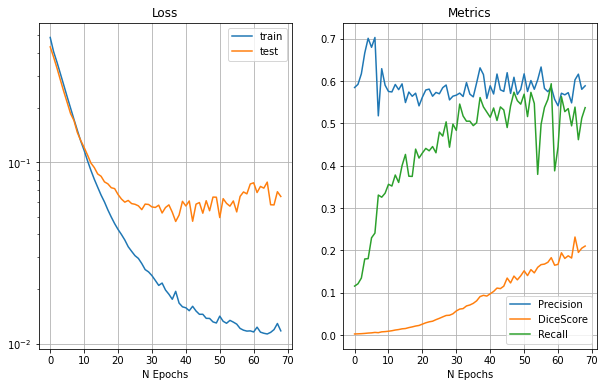

Loss on validation : 0.06467342014450177 
 Precision : 0.5887139184134347 
  Dice score : 0.2103248060795299 
  Recall : 0.537176377193671 


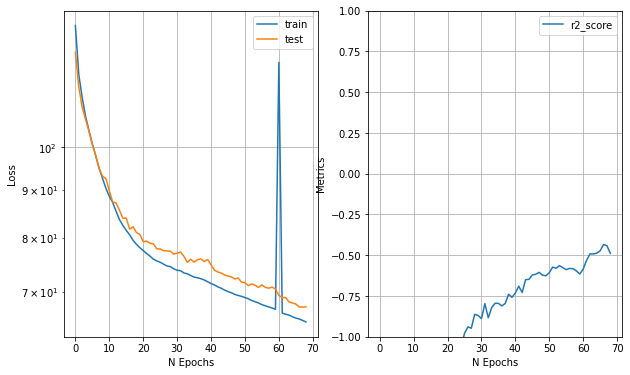

Loss on validation : 67.49280398949644 
 r2_score : -0.4884315313821883 
 


KeyboardInterrupt: 

In [107]:
N_epochs = 70

for epoch in range(N_epochs):

    y_pred_val = torch.tensor([0])
    y_true_val = torch.tensor([0])

    dist_score = 0.
    prec_score = 0.
    rec_score = 0.
    loss_val = 0.
    loss_val_s = 0.

    model.train()
    for X, y, y_s in train_dataloader:
        X = X.float()
        y1, y2 = model(X.to(device))
        y1 = y1.squeeze()
        y2 = y2.squeeze()
        loss1 = Loss1(y1.float(), y.to(device).float())
        loss2 = Loss2(y2.float(), y_s.to(device).float())

        loss = loss1 + loss2

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        l_m1.upd_loss(loss1.item() * torch.numel(y_s) / len(train_dataset))
        l_m2.upd_loss(loss2.item() * torch.numel(y_s) / len(train_dataset))
    #model.eval()
    with torch.no_grad():
        for X, _, y in test_dataloader:
            X = X.float()
            _, y_pred = model(X.to(device))
            y_pred = y_pred.squeeze().to('cpu')
            loss = Loss2(y.float(), y_pred.float())

            loss_val_s += loss.item() * torch.numel(y) / len(test_dataset)

            if torch.numel(y_pred) > 1:
                y_pred_val = torch.cat((y_pred_val, y_pred), dim=0)
                y_true_val = torch.cat((y_true_val, y.to('cpu')), dim=0)
    with torch.no_grad():
        for X,  y, _ in test_dataloader:
            #X = X[:, 1, :, :].float().unsqueeze(1)
            X = X.float()
            y = y.squeeze()
            y_pred, _ = model(X.to(device))
            y_pred = y_pred.squeeze().to('cpu')
            #Loss = BCEWithLogitsLoss(weight=wm.to(device))
            loss = Loss1(y_pred.to(device).float(), y.to(device).float())
            #mask = (y_pred.to('cpu') > 0) == y
            loss_val += loss.item() * y.shape[0] / len(test_dataset)
            #y_pred = torch.sigmoid(y_pred).to('cpu').detach()
            prec_score += Precision(y, torch.sigmoid(y_pred).to('cpu').detach() ).item() / len(test_dataset)
            dist_score += DiceScore(y, torch.sigmoid(y_pred).to('cpu').detach() ).item() / len(test_dataset)
            rec_score += Recall(y, torch.sigmoid(y_pred).to('cpu').detach() ).item() / len(test_dataset)

    l_m1.upd_metrics(loss_val,
                    {
                        'Precision' : prec_score,
                        'DiceScore' : dist_score,
                        'Recall' : rec_score
                    })


    l_m2.upd_metrics(loss_val_s,
                     { 'r2_score' : r2_score(y_pred_val.squeeze().detach().cpu().numpy(),
                                y_true_val.detach().cpu().numpy())} )

    clear_output()
    # plot losses
    fig, axes = plt.subplots(1, 2, figsize=(10,6))
    axes[0].set_xlabel('N Epochs')
    axes[0].grid()
    axes[1].grid()
    axes[0].set_title('Loss')
    axes[0].set_yscale('log')
    axes[1].set_xlabel('N Epochs')
    axes[1].set_title('Metrics')
    l_m1.plot(axes)
    plt.show()

    print(
        f'Loss on validation : { l_m1.val_loss_h[-1] } \n',
        'Precision : {} \n '.format(l_m1.metrics_h['Precision'][-1]),
        'Dice score : {} \n '.format(l_m1.metrics_h['DiceScore'][-1]),
        'Recall : {} '.format(l_m1.metrics_h['Recall'][-1]),
    )

    l_m1.clean_loss()

    fig, axes = plt.subplots(1, 2, figsize=(10,6))
    axes[0].set_xlabel('N Epochs')
    axes[0].grid()
    axes[1].grid()
    axes[0].set_ylabel('Loss')
    axes[0].set_yscale('log')
    axes[1].set_xlabel('N Epochs')
    axes[1].set_ylabel('Metrics')
    axes[1].set_ylim([-1, 1])
    l_m2.plot(axes)
    plt.show()

    print(
        f'Loss on validation : { l_m2.val_loss_h[-1] } \n',
        'r2_score : {} \n '.format(l_m2.metrics_h['r2_score'][-1])
    )

    l_m2.clean_loss()

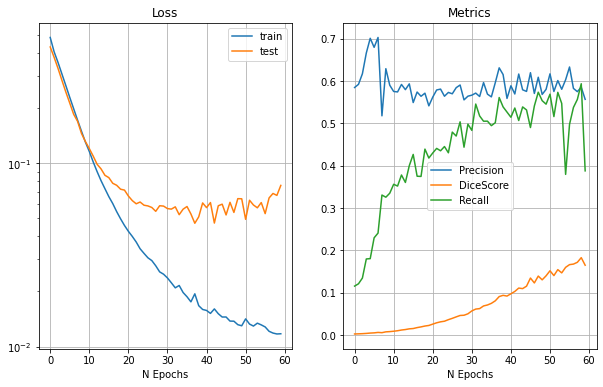

Loss on validation : 0.07578762919457636 
 Precision : 0.5567387196055629 
  Dice score : 0.16504040935583283 
  Recall : 0.3878812634556515 


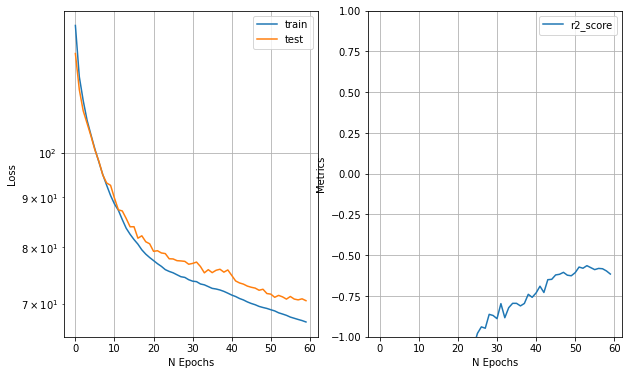

Loss on validation : 70.53695001817289 
 r2_score : -0.6151754718509019 
 


In [106]:
# plot losses
fig, axes = plt.subplots(1, 2, figsize=(10,6))
axes[0].set_xlabel('N Epochs')
axes[0].grid()
axes[1].grid()
axes[0].set_title('Loss')
axes[0].set_yscale('log')
axes[1].set_xlabel('N Epochs')
axes[1].set_title('Metrics')
l_m1.plot(axes)
plt.show()

print(
    f'Loss on validation : { l_m1.val_loss_h[-1] } \n',
    'Precision : {} \n '.format(l_m1.metrics_h['Precision'][-1]),
    'Dice score : {} \n '.format(l_m1.metrics_h['DiceScore'][-1]),
    'Recall : {} '.format(l_m1.metrics_h['Recall'][-1]),
)

l_m1.clean_loss()

fig, axes = plt.subplots(1, 2, figsize=(10,6))
axes[0].set_xlabel('N Epochs')
axes[0].grid()
axes[1].grid()
axes[0].set_ylabel('Loss')
axes[0].set_yscale('log')
axes[1].set_xlabel('N Epochs')
axes[1].set_ylabel('Metrics')
axes[1].set_ylim([-1, 1])
l_m2.plot(axes)
plt.show()

print(
    f'Loss on validation : { l_m2.val_loss_h[-1] } \n',
    'r2_score : {} \n '.format(l_m2.metrics_h['r2_score'][-1])
)